In [1]:
from LRL import *
from tqdm import tqdm

In [2]:
USE_CUDA

True

# Pong

In [3]:
def create_env():
    def _thunk():
        env = gym.make("PongNoFrameskip-v4")
        env = atari_wrappers.NoopResetEnv(env, noop_max=30)  # do nothing first from 1 to 30 frames 
        env = atari_wrappers.MaxAndSkipEnv(env, skip=4)      # return each 4-th frame with max over these 4 frames
        env = atari_wrappers.EpisodicLifeEnv(env)            # return done when loosing life
        env = atari_wrappers.FireResetEnv(env)               # pressing fire starts the game
        env = atari_wrappers.WarpFrame(env)                  # turn frame to grayscale 84x84
        env = atari_wrappers.ClipRewardEnv(env)              # get sign(reward) instead of reward
        env = atari_wrappers.ImageToPyTorch(env)             # pytorch wants channels x W x H
        return env
    return _thunk

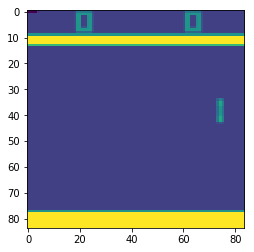

In [4]:
plt.imshow(create_env()().reset()[0].T)

In [5]:
class PongCnn(nn.Module):
    def __init__(self, linear):
        super(PongCnn, self).__init__()
        
        Conv = nn.Conv2d
        
        self.features = nn.Sequential(
            Conv(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            Conv(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            Conv(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        
        self.fc = nn.Sequential(
            linear(self.feature_size(), 512),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def feature_size(self):
        return self.features(torch.zeros(1, 1, 84, 84)).view(1, -1).size(1)

# DQN

In [7]:
config = {
    "make_env": create_env,
    "Qnetwork_FeatureExtractor": PongCnn,
    "QnetworkHead": Qnetwork,
    "Qnetwork_optimizer_args": {"lr": 0.0001},
    "target_update": 1000,
    "batch_size": 32,
    "replay_buffer_init": 10000,
    "gamma": 0.99,
    "replay_buffer_capacity": 1000000,
    "epsilon_start": 1.0, "epsilon_final": 0.01, "epsilon_decay": 30000
}

In [8]:
agent = eGreedy(TargetQAgent(QAgent(ReplayBufferAgent)))(config)

In [ ]:
for i in tqdm(range(1000)):
    agent.learn(1000)
    plot_durations(agent)   
    
    if i % 20 == 19:
        agent.save("Models/pong_dqn")

# Categorical DQN
(no target network)

In [6]:
config = {
    "make_env": create_env,
    "Qnetwork_FeatureExtractor": PongCnn,
    "QnetworkHead": CategoricalQnetwork,
    "Qnetwork_optimizer_args": {"lr": 0.0001},
    "batch_size": 32,
    "replay_buffer_init": 10000,
    "gamma": 0.99,
    "replay_buffer_capacity": 1000000,
    "epsilon_start": 1.0, "epsilon_final": 0.01, "epsilon_decay": 30000,    
    "Vmin": -10, "Vmax": 10, "num_atoms": 51
}

In [7]:
agent = eGreedy(CategoricalQAgent(ReplayBufferAgent))(config)

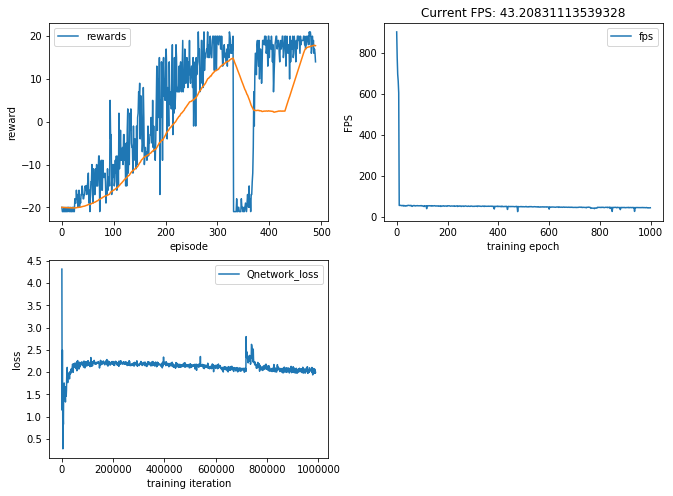

100%|████████████████████████████████████| 1000/1000 [5:55:14<00:00, 24.91s/it]


In [8]:
for i in tqdm(range(1000)):
    agent.learn(1000)
    plot_durations(agent)
    
    if i % 20 == 19:
        agent.save("Models/pong_c51_take2")

# Quantile Regression DQN

In [7]:
config = {
    "make_env": create_env,
    "Qnetwork_FeatureExtractor": PongCnn,
    "QnetworkHead": QuantileQnetwork,
    "Qnetwork_optimizer_args": {"lr": 0.0001},
    "target_update": 1000,
    "batch_size": 32,
    "replay_buffer_init": 10000,
    "gamma": 0.99,
    "replay_buffer_capacity": 1000000,
    "epsilon_start": 1.0, "epsilon_final": 0.01, "epsilon_decay": 30000,
    "quantiles": 51
}

In [8]:
agent = eGreedy(TargetQAgent(QuantileQAgent(ReplayBufferAgent)))(config)

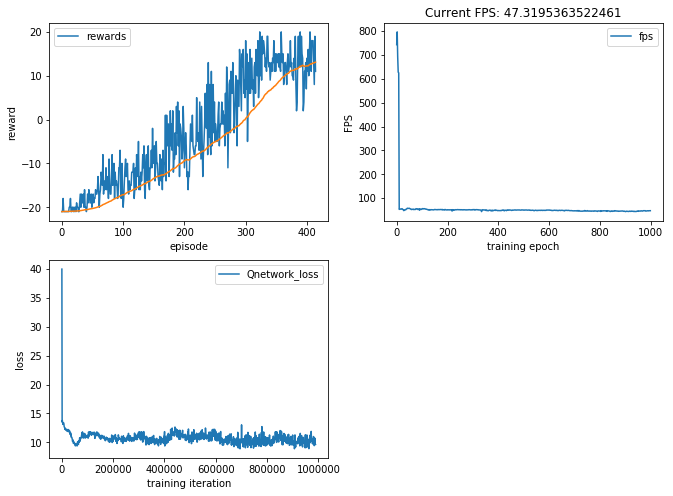

100%|████████████████████████████████████| 1000/1000 [5:42:57<00:00, 22.59s/it]


In [9]:
for i in tqdm(range(1000)):
    agent.learn(1000)
    plot_durations(agent)   
    
    if i % 20 == 19:
        agent.save("Models/pong_qrdqn_take2")

# Rainbow

In [6]:
config = {
    "make_env": create_env,
    "Qnetwork_FeatureExtractor": PongCnn,
    "QnetworkHead": DuelingCategoricalQnetwork,
    "Qnetwork_optimizer_args": {"lr": 0.0001}, # {"lr": 0.0000625, "eps": 0.00015},
    "Qnetwork_linear": NoisyLinear(std_init=0.5),
    "target_update": 1000,
    "batch_size": 32,
    "replay_buffer_nsteps": 3,
    "replay_buffer_init": 10000,
    "gamma": 0.99,
    "replay_buffer_capacity": 1000000,
    "rp_alpha": 0.5, "rp_beta_start": 0.4, "rp_beta_frames": 100000,
    "Vmin": -10, "Vmax": 10, "num_atoms": 51
}

In [7]:
agent = DoubleQAgent(CategoricalQAgent(NstepReplay(PrioritizedBufferAgent)))(config)

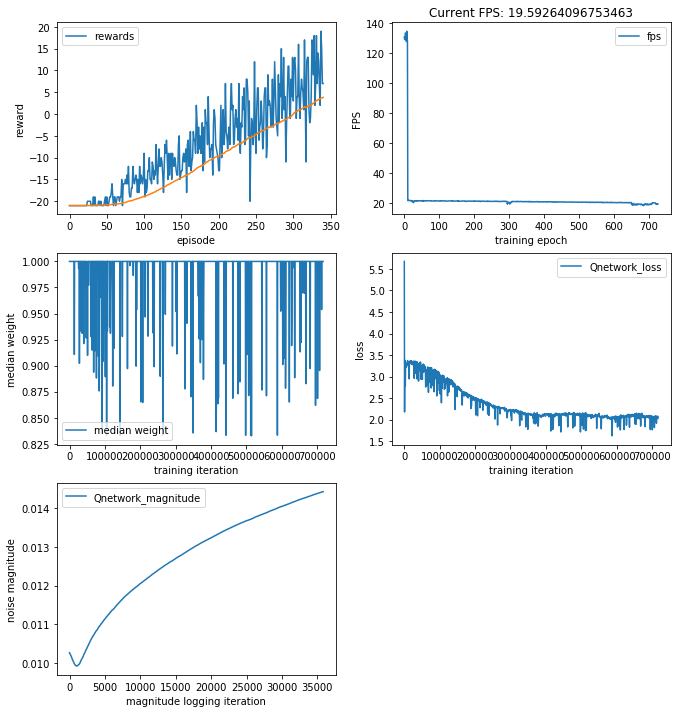

 73%|█████████████████████████▍         | 727/1000 [9:38:06<3:54:43, 51.59s/it]

In [ ]:
for i in tqdm(range(1000)):
    agent.learn(1000)
    plot_durations(agent)
    
    if i % 20 == 19:
        agent.save("Models/pong_rainbow_take2")

# A2C

In [6]:
config = {
    "make_env": create_env,
    "threads": 8,
    "ActorCritic_FeatureExtractor": PongCnn,
    "ActorCriticHead": ActorCritic, #_orth_init,
    "ActorCritic_optimizer": optim.Adam,
    "ActorCritic_optimizer_args": {"lr": 0.0001}, #{"lr": 7e-4, "eps": 1e-5},
    #"ActorCritic_clip_gradients": 0.5,
    "rollout": 5,
    "gamma": 0.99,
    "gae_tau": 0.95,
    "critic_loss_weight": 0.5,
    "entropy_loss_weight": 0.01
}

In [7]:
agent = GAE(A2C(Agent))(config)

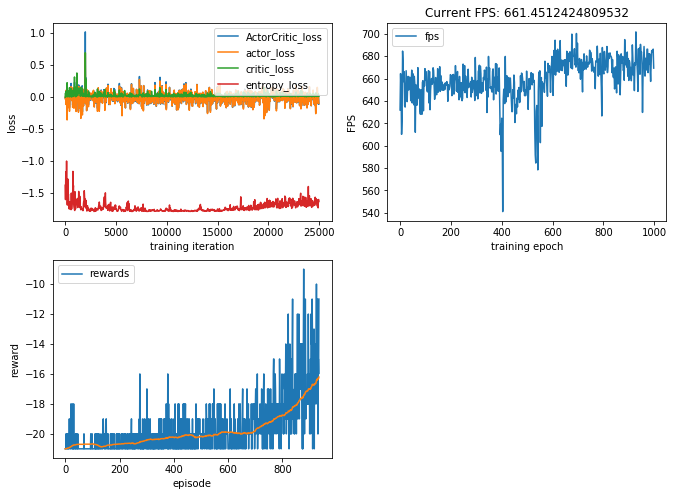

100%|██████████████████████████████████████| 1000/1000 [30:38<00:00,  1.82s/it]


In [8]:
for i in tqdm(range(1000)):
    agent.learn(1000)
    plot_durations(agent)
    
    if i % 20 == 19:
        agent.save("Models/pong_A2C_take2")

# PPO

In [12]:
config = {
    "make_env": create_env,
    "threads": 8,
    "ActorCritic_FeatureExtractor": PongCnn,
    "ActorCriticHead": ActorCritic, #_orth_init,
    "ActorCritic_optimizer": optim.Adam,
    "ActorCritic_optimizer_args": {"lr": 0.0001},  #{"lr": 0.0001, "eps": 1e-5}, 
    #"ActorCritic_clip_gradients": 0.5,
    "rollout": 128,
    "ppo_clip": 0.1, 
    "epochs": 3, 
    "batch_size": 32,
    "gamma": 0.99,
    "gae_tau": 0.95,
    "critic_loss_weight": 1,
    "entropy_loss_weight": 0.01,
}

In [13]:
agent = GAE(PPO(A2C(Agent)))(config)

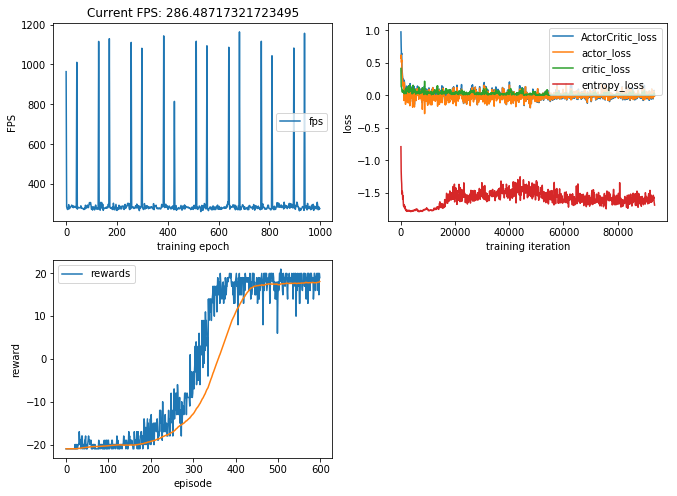


100%|████████████████████████████████████| 1000/1000 [1:03:18<00:00,  3.97s/it]

In [14]:
for i in tqdm(range(1000)):
    agent.learn(1000)
    plot_durations(agent)
    
    if i % 20 == 19:
        agent.save("Models/pong_PPO_take2")

In [15]:
agent.env.close()

# DQN parallel

In [16]:
config = {
    "make_env": create_env,
    "threads": 8,
    "optimize_iterations": 0.125,
    "Qnetwork_FeatureExtractor": PongCnn,
    "QnetworkHead": Qnetwork,
    "Qnetwork_optimizer_args": {"lr": 0.0001},
    "target_update": 1000,
    "batch_size": 128,
    "replay_buffer_init": 10000,
    "gamma": 0.99,
    "replay_buffer_capacity": 1000000,
    "epsilon_start": 1.0, "epsilon_final": 0.01, "epsilon_decay": 30000
}

In [17]:
agent = eGreedy(TargetQAgent(QAgent(ReplayBufferAgent)))(config)

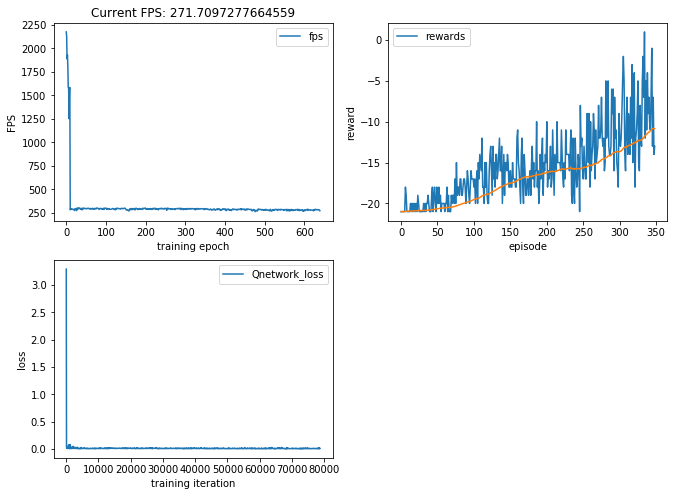


 64%|████████████████████████▉              | 640/1000 [39:49<23:55,  3.99s/it]

In [ ]:
for i in tqdm(range(1000)):
    agent.learn(1000)
    plot_durations(agent)   
    
    if i % 20 == 19:
        agent.save("Models/pong_dqn_8thr1step128bs_take2")

In [ ]:
agent.env.close()

# Categorical DQN parallel
(no target network)

In [ ]:
config = {
    "make_env": create_env,
    "threads": 8,
    "optimize_iterations": 0.125,
    "Qnetwork_FeatureExtractor": PongCnn,
    "QnetworkHead": CategoricalQnetwork,
    "Qnetwork_optimizer_args": {"lr": 0.0001},
    "batch_size": 128,
    "replay_buffer_init": 10000,
    "gamma": 0.99,
    "replay_buffer_capacity": 1000000,
    "epsilon_start": 1.0, "epsilon_final": 0.01, "epsilon_decay": 30000,    
    "Vmin": -10, "Vmax": 10, "num_atoms": 51
}

In [ ]:
agent = eGreedy(CategoricalQAgent(ReplayBufferAgent))(config)

In [ ]:
for i in tqdm(range(1000)):
    agent.learn(1000)
    plot_durations(agent)
    
    if i % 20 == 19:
        agent.save("Models/pong_c51_8thr1step128bs_take2")

In [ ]:
agent.env.close()

# Quantile Regression DQN parallel

In [ ]:
config = {
    "make_env": create_env,
    "threads": 8,
    "optimize_iterations": 0.125,
    "Qnetwork_FeatureExtractor": PongCnn,
    "QnetworkHead": QuantileQnetwork,
    "Qnetwork_optimizer_args": {"lr": 0.0001},
    "target_update": 1000,
    "batch_size": 128,
    "replay_buffer_init": 10000,
    "gamma": 0.99,
    "replay_buffer_capacity": 1000000,
    "epsilon_start": 1.0, "epsilon_final": 0.01, "epsilon_decay": 30000,
    "quantiles": 51
}

In [ ]:
agent = eGreedy(TargetQAgent(QuantileQAgent(ReplayBufferAgent)))(config)

In [ ]:
for i in tqdm(range(1000)):
    agent.learn(1000)
    plot_durations(agent)   
    
    if i % 20 == 19:
        agent.save("Models/pong_qrdqn_8thr1step128bs_take2")

In [ ]:
agent.env.close()

# Rainbow

In [ ]:
config = {
    "make_env": create_env,
    "threads": 8,
    "optimize_iterations": 0.25,
    "Qnetwork_FeatureExtractor": PongCnn,
    "QnetworkHead": DuelingCategoricalQnetwork,
    "Qnetwork_optimizer_args": {"lr": 0.0001}, # {"lr": 0.0000625, "eps": 0.00015},
    "Qnetwork_linear": NoisyLinear(std_init=0.5),
    "target_update": 1000,
    "batch_size": 128,
    "replay_buffer_nsteps": 3,
    "replay_buffer_init": 10000,
    "gamma": 0.99,
    "replay_buffer_capacity": 1000000,
    "rp_alpha": 0.5, "rp_beta_start": 0.4, "rp_beta_frames": 100000,
    "Vmin": -10, "Vmax": 10, "num_atoms": 51
}

In [ ]:
agent = DoubleQAgent(CategoricalQAgent(NstepReplay(PrioritizedBufferAgent)))(config)

In [ ]:
for i in tqdm(range(1000)):
    agent.learn(1000)
    plot_durations(agent)
    
    if i % 20 == 19:
        agent.save("Models/pong_rainbow_8thr2steps128bs_take2")

In [ ]:
agent.env.close()